In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import imutils
from sklearn.decomposition import PCA
import numpy as np
from scipy.stats import pearsonr
from scipy import signal
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [38]:

def find_edges(img):
    img = cv2.bilateralFilter(img,5,75,75)
    img = cv2.Canny(img,75,160)     
    return img

imgs_GreenGlass = list()
imgs_BrownGlass = list()
imgs_WhiteGlass = list()

for i in range(1,31):
    img = cv2.imread(f'GreenGlass/{i}.jpg',0)
    img = find_edges(img)  
    imgs_GreenGlass.append(img)
    
    img = cv2.imread(f'BrownGlass/{i}.jpg',0)
    img = find_edges(img) 
    imgs_BrownGlass.append(img)
    
    img = cv2.imread(f'WhiteGlass/{i}.jpg',0)
    img = find_edges(img) 
    imgs_WhiteGlass.append(img)

In [39]:

def preprocess(img,im_width = 720, c_size = 5):
    
    #переводим изображение в координаты точек
    data = np.argwhere(img>0)
    #нормируем
    scaled_data = data
    
    #преобразуем методом главных компонент
    model = PCA(n_components=2)
    model.fit(scaled_data)
    tdata = model.transform(scaled_data) 
    
    #масштабируем для перевода точек обратно в изображение
    im_width = 720
   
    points = (tdata - tdata.min(axis=0))/((tdata.max(axis=0) - tdata.min(axis=0)).max())

    offset = (1 - (points.max(axis=0) - points.min(axis=0)))/2
    
    im_points = ((points+offset)*im_width).astype(int)
    
    #рисуем точки    
    image = np.zeros((im_width,im_width))
    for point in im_points:
        image = cv2.circle(image,tuple(point),c_size,1,-1)
    return image

In [40]:

imgs_GreenGlass = [preprocess(img).flatten() for img in imgs_GreenGlass]
imgs_BrownGlass = [preprocess(img).flatten() for img in imgs_BrownGlass]
imgs_WhiteGlass = [preprocess(img).flatten() for img in imgs_WhiteGlass]


In [41]:
def predict_glass(img):
    img = find_edges(img)
    img = preprocess(img).flatten().reshape(1, -1)
    pred = reg.predict_proba(img)    
    lab = text_labels[np.argmax(pred)]
    p = pred.max()
    return lab,p
    

In [42]:
import random

while True:
    indices = list(range(30))
    random.shuffle(indices)

    all_data = np.vstack([
                          np.array(imgs_WhiteGlass)[indices[:24]],
                          np.array(imgs_BrownGlass)[indices[:24]],
                          np.array(imgs_GreenGlass)[indices[:24]]
                         ])

    labels  = np.array([0]*24 + [1]*24 + [2]*24)

    test = np.vstack([
                      np.array(imgs_WhiteGlass)[indices[24:]],
                      np.array(imgs_BrownGlass)[indices[24:]],
                      np.array(imgs_GreenGlass)[indices[24:]]
                     ])

    labels_test = np.array([0]*6 + [1]*6 + [2]*6)  # predict size

    text_labels = np.array(['WhiteGlass','BrownGlass', 'GreenGlass'])

    reg = LogisticRegression(solver='lbfgs', multi_class='auto')
    reg.fit(all_data, labels)

    score = reg.score(test, labels_test)
    print(f'score = {score}')
    if score > 0.6:
        break


score = 0.6111111111111112


Enter the path of your photo: ./predict2.jpg


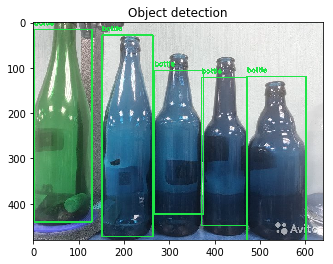

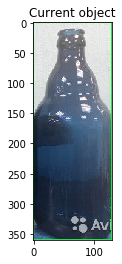

Brown glass detected
[ 53  82 113]


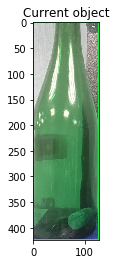

Green glass detected
[ 87 155  98]


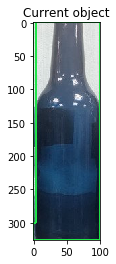

Green glass detected
[30 44 62]


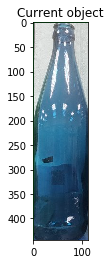

Brown glass detected
[ 44 125 163]


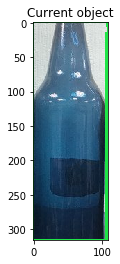

Brown glass detected
[ 37  90 127]
Total price is: 0.8


RuntimeError: Cannot run the event loop while another loop is running

In [59]:
from PIL import Image
import cvlib as cv
from cvlib.object_detection import draw_bbox

image_input = input('Enter the path of your photo: ')  # ./predict2.jpg
im = cv2.imread(f'{image_input}')
bbox, label, conf = cv.detect_common_objects(im)
output_image = draw_bbox(im, bbox, label, conf)
plt.title('Object detection')
plt.imshow(output_image)
plt.show()

greenCoeff = 0.1
brownCoeff = 0.2
whiteCoeff = 0.3

totalPrice = 0

for bottle in bbox:
    img = im[bottle[1]:bottle[3], bottle[0]:bottle[2]]
    plt.title('Сurrent object')
    plt.imshow(img)
    plt.show()
    
    
    pred = predict_glass(img)
    if pred[0] == 'GreenGlass':
        print('Green glass detected')
        totalPrice += greenCoeff
    if pred[0] == 'BrownGlass':
        print('Brown glass detected')
        totalPrice += brownCoeff
    if pred[0] == 'WhiteGlass':
        print('White glass detected')
        totalPrice += whiteCoeff
    
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_green=np.array([50,50,50])
    upper_green=np.array([70,255,255])

    lower_brown = np.array([50, 50, 20])
    upper_brown = np.array([138, 187, 194])

    lower_white = np.array([0,0,0])
    upper_white = np.array([0,0,255])
    
    height, width = hsv.shape[:2]
    print((img[height//2, width//2]))

    maskGreen = cv2.inRange(hsv, lower_green, upper_green)
    resGreen = cv2.bitwise_and(img, img, mask=maskGreen)
    #plt.title('Green')
    #plt.imshow(resGreen)
    #plt.show()

    maskBrown = cv2.inRange(hsv, lower_brown, upper_brown)
    resBrown = cv2.bitwise_and(img, img, mask=maskBrown)
    #plt.title('Brown')
    #plt.imshow(resBrown)
    #plt.show()

    maskWhite = cv2.inRange(hsv, lower_white, upper_white)
    resWhite = cv2.bitwise_and(img, img, mask=maskWhite)
    #plt.title('White')
    #plt.imshow(resWhite)
    #plt.show()
    
    
print('Total price is: ' + str(totalPrice))

import httpx

accountID = 45531
r = httpx.get('https://baltoshackos.herokuapp.com/Home/SetUserMoney/AccId?=' + 
              str(accountID) + '&value=' + str(totalPrice))
print(r)
print(r.text)

'''
image_input = input('Enter the path of your photo: ')  # ./predict2.jpg
img = cv2.imread(f'{image_input}') #im

greenCoeff = 0.1
brownCoeff = 0.2
whiteCoeff = 0.3

totalPrice = 0
    
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_green=np.array([50,50,50])
upper_green=np.array([70,255,255])

lower_brown = np.array([25,50,50])
upper_brown = np.array([32,255,255])

lower_white = np.array([0,0,0])
upper_white = np.array([0,0,255])
    
#height, width = hsv.shape[:2]
#print((img[height//2, width//2]))

maskGreen = cv2.inRange(hsv, lower_green, upper_green)
resGreen = cv2.bitwise_and(img, img, mask=maskGreen)
bbox, label, conf = cv.detect_common_objects(resGreen)
output_image_green = draw_bbox(resGreen, bbox, label, conf)
plt.title('Green')
plt.imshow(output_image_green)
plt.show()

maskBrown = cv2.inRange(hsv, lower_brown, upper_brown)
resBrown = cv2.bitwise_and(img, img, mask=maskBrown)
bbox, label, conf = cv.detect_common_objects(resBrown)
output_image_brown = draw_bbox(resBrown, bbox, label, conf)
plt.title('Brown')
plt.imshow(output_image_brown)
plt.show()

maskWhite = cv2.inRange(hsv, lower_white, upper_white)
resWhite = cv2.bitwise_and(img, img, mask=maskWhite)
bbox, label, conf = cv.detect_common_objects(resWhite)
output_image_white = draw_bbox(resWhite, bbox, label, conf)
plt.title('White')
plt.imshow(output_image_white)
plt.show()
    
    
#print('Total price is: ' + str(totalPrice))
'''

In [8]:
import cv2

inputImage = cv2.imread('./qr.png')

# Display barcode and QR code location
def display(im, bbox):
    n = len(bbox)
    for j in range(n):
        cv2.line(im, tuple(bbox[j][0]), tuple(bbox[(j+1) % n][0]), (255,0,0), 3)
    
qrDecoder = cv2.QRCodeDetector()
 
# Detect and decode the qrcode
data,bbox,rectifiedImage = qrDecoder.detectAndDecode(inputImage)
if len(data)>0:
    print("Decoded data from QR code: {}".format(data))

print(data)

Decoded data from QR code: 54321
54321


In [ ]:
import cv2
import sys

cascPath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

video_capture = cv2.VideoCapture(0)

while True:
    ret, frame = video_capture.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()
